In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataproc.operations.hitp as hitpops
import pyFAI.detectors as dets
import pyFAI

from pathlib import Path

import glob

# Prep data

In [3]:
dp_str = 'C:\\Users\\roberttk\\Desktop\\SLAC_RA\\machine-learning\\data\\diffraction\\JHS007'
dp = Path(dp_str)

C:\Users\roberttk\Desktop\SLAC_RA\machine-learning\data\diffraction\JHS007\Phase_Mapping_ML\JHS007_X_11292019_CoSbZr500_t60_0014_bkgdSub_1D.csv


(-10.0, 250.0)

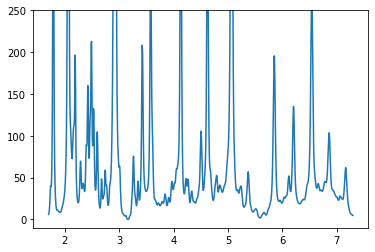

In [4]:
bg_sub_path = dp / 'Phase_Mapping_ML'
bg_sub_list = glob.glob(str(bg_sub_path / '*.csv'))
print(bg_sub_list[0])
#preview 
test = pd.read_csv(bg_sub_list[0], names=['q', 'I'])
plt.plot(test['q'], test['I'])
plt.ylim((-10, 250))


  File "<ipython-input-5-63e5caccb7a3>", line 24, in <module>
    p = pyFAI.AzimuthalIntegrator(wavelength=expInfo['wavelength'])
C:\Users\roberttk\Desktop\SLAC_RA\machine-learning\data\diffraction\JHS007\JHS007_X_11292019_CoSbZr500_t60_0014.tif


Detector Detector	 Spline= None	 PixelSize= 7.500e-11, 7.500e-11 m
Wavelength= 8.052000e-11m
SampleDetDist= 1.508827e-07m	PONI= 8.326019e-08, 7.636578e-08m	rot1=0.001034  rot2= 0.549399  rot3= 0.000080 rad
DirectBeamDist= 0.000mm	Center: x=1016.130, y=2341.900 pix	Tilt=31.478 deg  tiltPlanRotation= 90.097 deg

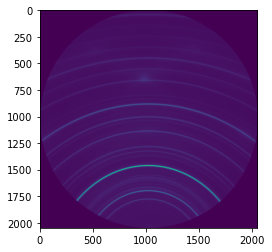

In [5]:
# for p in glob.glob(str(bg_sub_path / '*.tif'))
# fp = glob.glob(str(dp.parents[0] / 'FeSeTe' / '*.tif'))[0]
fp = glob.glob(str(dp / '*.tif'))[0]
print(fp)
# Figure out experimental info 
det = dets.Dexela2923()

expInfo = {}
expInfo['dist'] = 2358.9111 * det.pixel1
expInfo['wavelength'] = 0.8052 * 1E-10
expInfo['poni1'] = 1016.13 * det.pixel1
expInfo['poni2'] = 2341.90 * det.pixel2 
expInfo['detector'] = det
expInfo['tilt_alpha'] = 4.7107
expInfo['tilt_delta'] = 0.5494

rot = (np.pi * 2 - expInfo['tilt_alpha']) / (2 * np.pi) * 360
tilt = expInfo['tilt_delta'] / (2 * np.pi) * 360

im = hitpops.load_image(Path(fp))
plt.imshow(im)
detector_mask = np.ones(im.shape)*(im<= 0)

p = pyFAI.AzimuthalIntegrator(wavelength=expInfo['wavelength'])
p.setFit2D(expInfo['dist']*0.001, 1016.13, 2341.90, 
            tilt, rot, det.pixel1, det.pixel2)

# This is fucking dumb.  SetFit2d takes in entirely different units from AzimuthalIntegrator object
# setFit2D: dist in mm, centers in pixels, tilt/rot in deg
# azInt: dist in m, centers in m, tilt/rot in rad

In [6]:
Q, I = p.integrate1d(im, 1000, mask=detector_mask)
cake, _, _ = p.integrate2d(im, 1000, 1000, mask=detector_mask)

(0.0, 400.0)

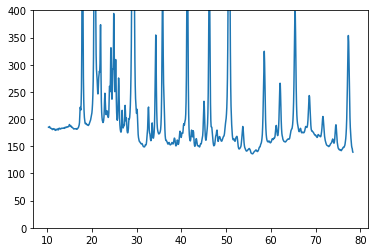

In [41]:
plt.plot(Q[20:-45], I[20:-45])
plt.ylim((0, 400))

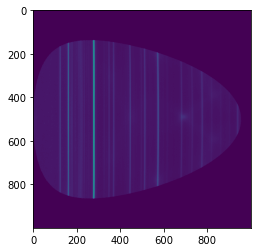

In [8]:
plt.imshow(cake)

# Try different methods of background fitting

In [9]:
from scipy.optimize import basinhopping
from numpy.polynomial.chebyshev import chebval
from scipy.interpolate import interp1d


x = Q.copy()
y = np.log(I).copy()*100
def cheb_test(x, y):

    def chebFunc(x, *params):
            """
            Modified chebyshev function with 1/x 
            """
            params = params[0]
            y = chebval(x, params[:4])
            E = params[4]
            y = y + E/x
            return y


    def objFunc(*params):
        """
        implement cost function for modified chevbyshev function
        varies cost to emphasize low Q region
        Scoping pulls trimmed x, y data from surrounding scope... this is bad

        return: cost of fit 
        """
        
        params = params[0]
        J = 0
        fit = chebval(downX, params[:4])
        E = params[4]
        fit = fit + E / downX

        for i in range(len(downY)):
            if downX[i] < 1:    # Treat low Q equally
                J = J + (downY[i] - fit[i])**4
            else:
                if downY[i] < fit[i]:
                    J = J + (downY[i] - fit[i])**4
                if downY[i] >= fit[i]:
                    J = J + (downY[i] - fit[i])**2
        return J

    # Create a sparse data set for fitting
    downX = x[::50]
    downY = y[::50]

    # Remove points above median + 10% of range
    medianY = np.median(downY)
    rangeY = np.max(downY) - np.min(downY)
    downX = downX[downY <= (medianY + 0.1*rangeY)]
    downY = downY[downY <= (medianY + 0.1*rangeY)]

    # Re-append end values to try and fix boundary conditions
    downX = np.append(np.append(x[0:30:5], downX), x[-30:-1:5])
    downY = np.append(np.append(y[0:30:5], downY), y[-30:-1:5])

    x0 = [1,1,1,1,1]
    #appears to converge quickly, take 10 iterations rather than 100
    result = basinhopping(objFunc, x0, niter=100) 
    bkgd_sparse = chebFunc(x, result.x)
    # create function that interpolates sparse bkgd
    f = interp1d(x, bkgd_sparse, kind='cubic', bounds_error=False)

    # expressed background values
    bkgd1 = f(x)
    subDataY = y - bkgd1

    # Dump any nan values in all data
    finalDataY = subDataY[~np.isnan(subDataY)]
    finalDataX = x[~np.isnan(subDataY)]
    bkgd = bkgd1[~np.isnan(subDataY)]

    fig, ax = plt.subplots()
    ax.plot(downX, downY, 'ro', label='downsampled')
    ax.plot(x, y, label='raw')
    ax.plot(x, bkgd, label='cheb fit')
    ax.plot(finalDataX, finalDataY, label='subbed data')
    fig.legend()

    return fig, ax

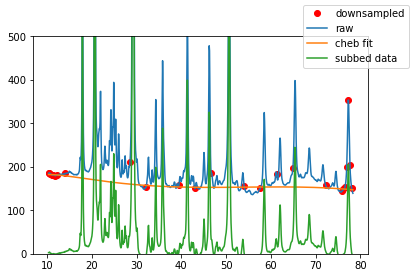

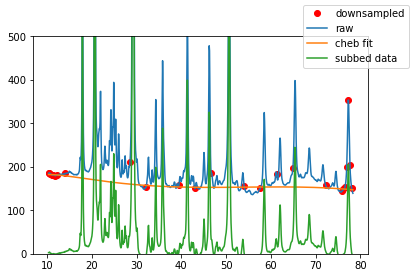

In [42]:
fig1, ax1 = cheb_test(Q[20:-45], I[20:-45])
ax1.set_ylim((0, 500))
fig1

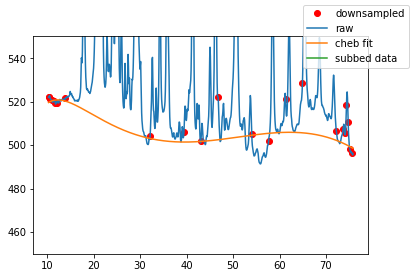

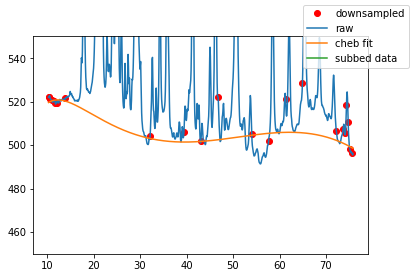

In [11]:
fig2, ax2 = cheb_test(Q[20:-80], np.log(I[20:-80])*100)
ax2.set_ylim((450, 550))
fig2

# Try gaussian process...

0.14118463820161664


(100.0, 400.0)

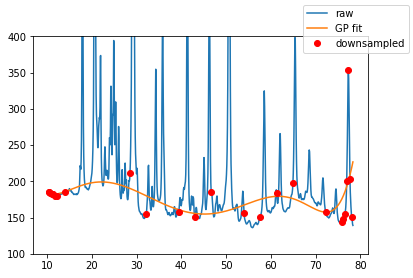

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.optimize import basinhopping
from numpy.polynomial.chebyshev import chebval
from scipy.interpolate import interp1d


x = Q[20:-45].copy()
y = I[20:-45].copy()
# def gp_test(x, y):
# Create a sparse data set for fitting
downX = x[::50]
downY = y[::50]

# Remove points above median + 10% of range
medianY = np.median(downY)
rangeY = np.max(downY) - np.min(downY)
downX = downX[downY <= (medianY + 0.1*rangeY)]
downY = downY[downY <= (medianY + 0.1*rangeY)]

# Re-append end values to try and fix boundary conditions
downX = np.append(np.append(x[0:30:5], downX), x[-30:-1:5])
downY = np.append(np.append(y[0:30:5], downY), y[-30:-1:5])

# setup kernel (try to increase length scale)
# Probably need to more carefully choose points...  Since GP will hit the points exactly every time
# For some reason adding 1*RBF messes with fitting, makes it far overfit
kernel = RBF(length_scale=100, length_scale_bounds=(50, 1e5))

# Try gp fit 
gpr = GaussianProcessRegressor(kernel=kernel, 
                    random_state=0).fit(downX.reshape(-1, 1), downY)
print(gpr.score(downX.reshape(-1, 1), downY))

# expressed background values
bkgd1, std = gpr.predict(x.reshape(-1, 1), return_std=True)
subDataY = y - bkgd1

# Dump any nan values in all data
finalDataY = subDataY[~np.isnan(subDataY)]
finalDataX = x[~np.isnan(subDataY)]
bkgd = bkgd1[~np.isnan(subDataY)]

fig, ax = plt.subplots()
ax.plot(x, y, label='raw')
ax.plot(x, bkgd, label='GP fit')
ax.plot(downX, downY, 'ro', label='downsampled')

# ax.plot(finalDataX, finalDataY, label='subbed data')
fig.legend()
ax.set_ylim((100, 400))
# return fig, ax

(100.0, 300.0)

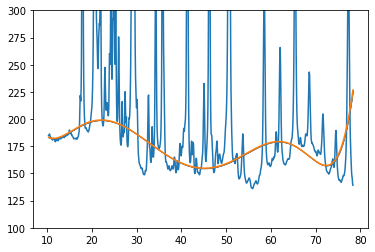

In [85]:
plt.plot(x, y)
plt.plot(x, bkgd)
plt.fill_between(x, bkgd - np.sqrt(std), bkgd + np.sqrt(std), alpha=0.5, color='k')
plt.ylim(100, 300)

In [82]:
np.max(std)

0.0036762956267995645